In [1]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import shap


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [94]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [95]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [96]:
review_df.describe()

,helpful_votes,location_id,review_id,rating
count,5909.000000,5.909000e+03,5.909000e+03,5909.000000
mean,1.058216,6.483167e+06,7.590446e+08,4.153833
std,5.625108,4.877561e+06,1.844114e+08,1.067077
min,0.000000,3.110380e+05,1.049076e+08,1.000000
25%,0.000000,2.578107e+06,6.573250e+08,4.000000
50%,0.000000,6.017599e+06,7.832754e+08,4.000000
75%,1.000000,8.818088e+06,9.240324e+08,5.000000
max,182.000000,2.714283e+07,9.653184e+08,5.000000


In [97]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [98]:
df_review_yelp = pd.read_csv(f"{REVIEWS_DATASET_DIR}/yelp_review_train.csv")
df_review_yelp.head(5)

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [99]:
import random

def map_label_to_rating(val):
    return val + 1

def map_generate_location_id():
    return f"YELP{random.randint(10000, 99999)}"

df_review_yelp['location_id'] = df_review_yelp['text'].apply(lambda x: map_generate_location_id())
df_review_yelp['review'] = df_review_yelp['text']
df_review_yelp['rating'] = df_review_yelp['label'].apply(map_label_to_rating)

df_review_yelp = df_review_yelp[['rating', 'review', 'location_id']]


In [9]:
df_review_yelp

,rating,review,location_id
0,5,dr. goldberg offers everything i look for in a...,YELP43272
1,2,"Unfortunately, the frustration of being Dr. Go...",YELP56653
2,4,Been going to Dr. Goldberg for over 10 years. ...,YELP78819
3,4,Got a letter in the mail last week that said D...,YELP18889
4,1,I don't know what Dr. Goldberg was like before...,YELP54051
...,...,...,...
649995,5,I had a sprinkler that was gushing... pipe bro...,YELP89720
649996,1,Phone calls always go to voicemail and message...,YELP86683
649997,1,Looks like all of the good reviews have gone t...,YELP82104
649998,5,I was able to once again rely on Yelp to provi...,YELP29953


In [110]:
df_postive_yelp = df_review_yelp[df_review_yelp['rating'].isin([5])]
df_natural_yelp = df_review_yelp[df_review_yelp['rating'].isin([3, 4])]
df_negative_yelp = df_review_yelp[df_review_yelp['rating'].isin([1, 2])]

print(f"Positive [{len(df_postive_yelp)}] / Natural [{len(df_natural_yelp)}] / Negative [{len(df_negative_yelp)}]")

Positive [130000] / Natural [260000] / Negative [260000]


In [111]:
df_postive = review_df[review_df['rating'].isin([5])]
df_natural = review_df[review_df['rating'].isin([3, 4])]
df_negative = review_df[review_df['rating'].isin([1, 2])]

print(f"Positive [{len(df_postive)}] / Natural [{len(df_natural)}] / Negative [{len(df_negative)}]")

Positive [2871] / Natural [2571] / Negative [467]


In [9]:
# binary_url = 'https://github.com/BrownDSI/word2vec-slim/releases/' + \
#              'download/v0.1/GoogleNews-vectors-negative300-slim.bin.gz'
# r = requests.get(binary_url)
# open('google-word2vec-slim.bin.gz', 'wb').write(r.content);

# model = KeyedVectors.load_word2vec_format('google-word2vec-slim.bin.gz', binary = True)

In [10]:
# print(os.path.exists(f"{NLTK_DATA_PATH}/tokenizers/punkt")) 

In [11]:
# 1. Data Preparation
# nltk.download ('all', download_dir=NLTK_DATA_PATH)

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [13]:
from nltk.corpus import stopwords 

custom_stopwords = set(stopwords.words('english'))

In [14]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [112]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [113]:
combined_positive_df = pd.concat([df_postive_yelp.iloc[:-len(df_postive)], df_postive])
combined_natural_df = pd.concat([df_natural_yelp.iloc[:-len(df_natural)], df_natural])
combined_negative_df = pd.concat([df_negative_yelp.iloc[:-len(df_negative)], df_negative])

In [114]:
print(f"{len(combined_positive_df)} / {len(combined_natural_df)} / {len(combined_negative_df)}")

130000 / 260000 / 260000


In [18]:
selected_column_trained = ['rating', 'location_id', 'review', 'helpful_vote']
full_combined_df = pd.concat([combined_positive_df[selected_column_trained], combined_natural_df[selected_column_trained], combined_negative_df[selected_column_trained]])

In [115]:
print(len(full_combined_df))
print(full_combined_df)

650000
      rating location_id                                             review  \
0          5   YELP43272  dr. goldberg offers everything i look for in a...   
5          5   YELP57453  Top notch doctor in a top notch practice. Can'...   
6          5   YELP76804  Dr. Eric Goldberg is a fantastic doctor who ha...   
14         5   YELP13334  This place was DELICIOUS!!  My parents saw a r...   
15         5   YELP22507  Can't miss stop for the best Fish Sandwich in ...   
...      ...         ...                                                ...   
5814       1    10000684  Personally tough this place is not maintained ...   
5859       1     1390151  Found this on social, the owner parked his/her...   
5866       2     6668995  Wat Intharam was apparently built during the A...   
5867       2     6668995  if you expect to find authentic buddhist teach...   
5882       1      456191  Living in Thailand many years, having Thai hus...   

                                         cle

In [116]:
# Apply preprocessing to the review texts
full_combined_df['cleaned_review'] = full_combined_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in full_combined_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



In [117]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [118]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

full_combined_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [119]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [4, 3]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

full_combined_df['sentiment'] = full_combined_df['rating'].apply(map_rating_to_sentiment)

In [120]:
full_combined_df.head(5)

,rating,location_id,review,cleaned_review,embedding,sentiment,location_id_numeric
0,5,YELP43272,dr. goldberg offers everything i look for in a...,dr goldberg offer everything look general prac...,"[[0.7459096908569336, 0.05217102915048599, 0.4...",positive,NaN
5,5,YELP57453,Top notch doctor in a top notch practice. Can'...,top notch doctor top notch practice cant say s...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive,NaN
6,5,YELP76804,Dr. Eric Goldberg is a fantastic doctor who ha...,dr eric goldberg fantastic doctor correctly di...,"[[0.6843482851982117, -0.5332671999931335, -0....",positive,NaN
14,5,YELP13334,This place was DELICIOUS!! My parents saw a r...,place delicious parent saw recommendation visi...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive,NaN
15,5,YELP22507,Can't miss stop for the best Fish Sandwich in ...,cant miss stop best fish sandwich pittsburgh,"[[0.6843482851982117, -0.5332671999931335, -0....",positive,NaN


In [ ]:
# from sklearn.utils import resample

# # Assuming `review_df` is your original DataFrame with a 'sentiment' column

# # 1. Separate the data by class
# df_positive = review_df[review_df.sentiment == 'positive']
# df_neutral = review_df[review_df.sentiment == 'neutral']
# df_negative = review_df[review_df.sentiment == 'negative']

# # 2. Resample the minority classes
# # For example, oversample the neutral and negative classes to match the positive class
# df_neutral_upsampled = resample(df_neutral,
#                                 replace=True,  # Sample with replacement
#                                 n_samples=len(df_positive),  # Match number of positive class samples
#                                 random_state=42)  # Reproducible results

# df_negative_upsampled = resample(df_negative,
#                                  replace=True,  # Sample with replacement
#                                  n_samples=len(df_positive),  # Match number of positive class samples
#                                  random_state=42)  # Reproducible results

# # 3. Combine the resampled DataFrames
# df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# # 4. Shuffle the combined DataFrame
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # 5. Check the distribution of the classes
# print(df_balanced['sentiment'].value_counts())


In [121]:
full_combined_df.to_csv("../dataset/full_embled_review_combined.csv")

In [122]:
df_balanced = full_combined_df

print(df_balanced['sentiment'].value_counts())

sentiment
neutral     260000
negative    260000
positive    130000
Name: count, dtype: int64


In [123]:
df_balanced['location_id_numeric'] = pd.to_numeric(df_balanced['location_id'], errors='coerce')

# Filter out rows where 'location_id_numeric' is NaN (i.e., non-integer)
filtered_df = df_balanced[df_balanced['location_id_numeric'].notna()]
trained_df = df_balanced[df_balanced['location_id_numeric'].isna()] 

# Drop the helper 'location_id_numeric' column if you don't need it anymore
validate_review_df = filtered_df.drop(columns=['location_id_numeric'])
training_review_df = trained_df.drop(columns=['location_id_numeric'])


In [124]:
df_sampled = training_review_df.groupby('sentiment').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_3059/4209710448.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [127]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_sampled['cleaned_review'])

X = tokenizer.texts_to_sequences(df_sampled['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_sampled['sentiment'].map(label_mapping)

In [125]:
X.shape

(30000, 300)

In [126]:
y.shape

(30000,)

In [128]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (21000, 300)
y_train shape: (21000,)
X_test shape: (9000, 300)
y_test shape: (9000,)


In [130]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Step 6: Build the LSTM Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 
max_len = 100

# สร้างโมเดลด้วย L2 Regularization และ Dropout
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(LSTM(64, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # สมมติว่ามี 3 คลาส

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [131]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [132]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [133]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [134]:
class_weights_dict = dict(enumerate(class_weights))

In [135]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0}

In [136]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir=f'../../logs')

In [138]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/LSTM_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, tensorboard],
                    class_weight=None)


Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 353ms/step - accuracy: 0.5757 - loss: 1.5479 - val_accuracy: 0.6852 - val_loss: 0.7400
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 122s 370ms/step - accuracy: 0.7571 - loss: 0.6290 - val_accuracy: 0.6898 - val_loss: 0.7286
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 119s 362ms/step - accuracy: 0.8155 - loss: 0.5060 - val_accuracy: 0.6849 - val_loss: 0.7729
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 120s 364ms/step - accuracy: 0.8592 - loss: 0.4261 - val_accuracy: 0.6812 - val_loss: 0.8795
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 352ms/step - accuracy: 0.8878 - loss: 0.3517 - val_accuracy: 0.6697 - val_loss: 0.9129
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 352ms/step - accuracy: 0.8908 - loss: 0.3359 - val_accuracy: 0.6709 - val_loss: 1.0328
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 351ms/step - accuracy: 0.9125 - loss: 0.2804 - val_accuracy: 0.6621 - val_loss: 1.1007


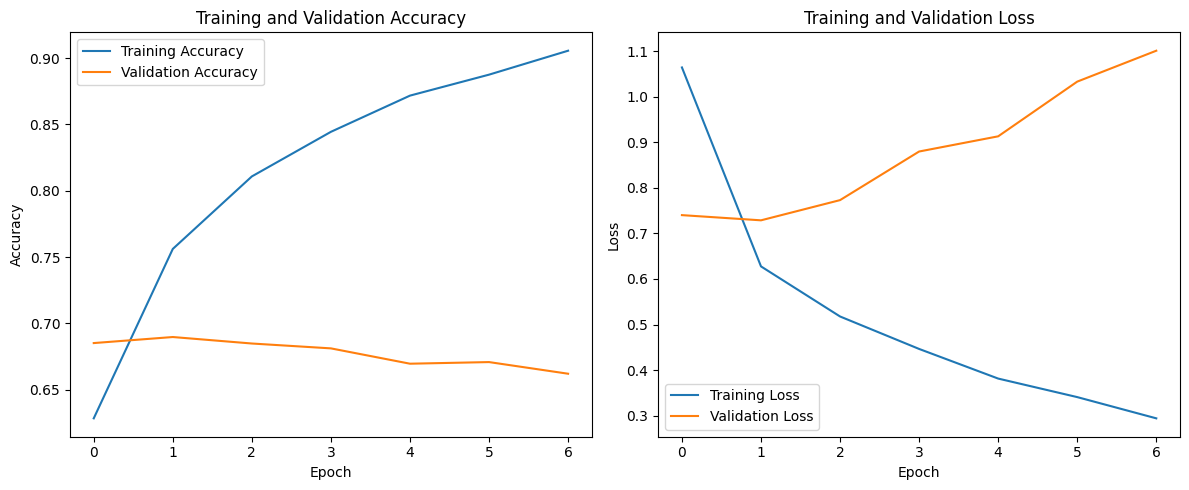

In [139]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [140]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model('../../models/LSTM_models_sample.keras')

In [141]:
len(validate_review_df)

5909

In [142]:
validate_review_df.sort_values(by='sentiment', ascending=True).head(10)

,rating,location_id,review,cleaned_review,embedding,sentiment
5882,1,456191,"Living in Thailand many years, having Thai hus...",living thailand many year thai husband kid can...,"[[-0.11702033132314682, -0.5730656981468201, -...",negative
2463,1,6277182,The floating market is a dead abandoned place ...,floating market dead abandoned place absolutel...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
2465,1,6277182,Without of your time. It is not difficult. The...,without time difficult lot closed store open w...,"[[-0.25492197275161743, -0.7028679847717285, -...",negative
2500,1,3445712,Tourist trap! They try to charge you 300 baht ...,tourist trap try charge baht per person enter ...,"[[0.2401776760816574, -0.5479413866996765, 0.0...",negative
2520,2,6669305,"When people think of ""national parks"" they nor...",people think national park normally except som...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
2538,1,2086145,ROBBERY! DON`T GO!!!\n400 Bath one person! For...,robbery dont go bath one person walkin around ...,"[[1.0832406282424927, 0.14952969551086426, 0.0...",negative
2587,1,4322440,Just stop by and didn't do a tour at this site...,stop didnt tour site commence visited place ca...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
2588,2,4322440,Dun waste your time going there. Is abandon. N...,dun waste time going abandon signage place roa...,"[[1.065230369567871, -0.7339228987693787, 0.41...",negative
2622,2,10224093,Hired a car to take us from Bangkok to Sarabur...,hired car take u bangkok saraburi saw somethin...,"[[0.613468587398529, -1.304443359375, 0.206912...",negative
2623,2,10224093,Viewed in late November; sunflowers not fully ...,viewed late november sunflower fully bloom bet...,"[[2.205598831176758, -1.3279869556427002, 0.31...",negative


In [143]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(validate_review_df['cleaned_review'])

X_val_resampled = tokenizer.texts_to_sequences(validate_review_df['cleaned_review'])
X_val_resampled = pad_sequences(X_val_resampled, maxlen=max_sequence_length)

y_val_resampled = validate_review_df['sentiment'].map(label_mapping)

In [144]:
y_val_resampled.shape

(5909,)

In [145]:
X_val_resampled.shape

(5909, 300)

In [ ]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
# lstm_preds = best_model.predict(X_val_resampled)
# lstm_preds = np.argmax(lstm_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
# gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
# gb_clf.fit(lstm_preds.reshape(-1, 1), y_val_resampled)

# # ทำนายผลลัพธ์ด้วย Gradient Boosting
# ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
# print(classification_report(y_val_resampled, ensemble_preds))
# print(confusion_matrix(y_val_resampled, ensemble_preds))

In [ ]:
# สร้างโมเดล Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))

In [117]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model)],
    voting='hard')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.4108888888888889


In [147]:
X_val_resampled

array([[    0,     0,     0, ...,     2,   116,  4076],
       [    0,     0,     0, ...,   143,    23,   105],
       [    0,     0,     0, ...,  1663,   392,    60],
       ...,
       [    0,     0,     0, ..., 16084,    29,     2],
       [    0,     0,     0, ...,  3645,  2468,  1542],
       [    0,     0,     0, ...,   464,   589,  1905]], dtype=int32)

In [148]:
y_val_resampled

0       2
3       2
4       2
5       2
6       2
       ..
5814    0
5859    0
5866    0
5867    0
5882    0
Name: sentiment, Length: 5909, dtype: int64

In [149]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1761
Missing indices count: 7239


In [150]:
predict_label = y_val_resampled

In [152]:
lstm_preds = best_model.predict(X_val_resampled)
lstm_preds = np.argmax(lstm_preds, axis=1)

conf_matrix = confusion_matrix(y_val_resampled, lstm_preds)

print("Accuracy:", accuracy_score(y_val_resampled, lstm_preds))
print(classification_report(y_val_resampled, lstm_preds))
print(conf_matrix)

185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step
Accuracy: 0.34642071416483333
              precision    recall  f1-score   support

           0       0.08      0.30      0.12       467
           1       0.44      0.33      0.38      2571
           2       0.49      0.37      0.42      2871

    accuracy                           0.35      5909
   macro avg       0.34      0.33      0.31      5909
weighted avg       0.43      0.35      0.38      5909

[[ 139  133  195]
 [ 793  849  929]
 [ 880  932 1059]]


In [153]:
import plotly.graph_objects as go

class_names = ['Class 0', 'Class 1', 'Class 2']

fig = go.Figure(data=go.Heatmap(
        z=conf_matrix,
        x=[f'Predicted {label}' for label in class_names],  # predicted labels
        y=[f'Actual {label}' for label in class_names],  # actual labels
        hoverongaps=False,
        colorscale='Blues'  # Customize colorscale as needed
    ))

# Update layout for better readability
fig.update_layout(
    title='Confusion Matrix for 3 Classes',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    font=dict(size=14)
)

# Show the plot
fig.show()

In [154]:
redicted_df = pd.DataFrame({'predicted': lstm_preds}, index=y_val_resampled.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val_resampled, redicted_df], axis=1)

In [155]:
predict_df

,sentiment,predicted
0,2,0
3,2,1
4,2,0
5,2,0
6,2,1
...,...,...
5814,0,2
5859,0,0
5866,0,2
5867,0,0


In [90]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [91]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
0,0,2209612,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,5,Wat Ratchabophit,Bangkok,P03013220,joy,besides elegant grand palace <OOV> wat pra kae...
3,0,2209612,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> buddhist temple l...
4,4,2209612,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> historic royal te...
5,3,2273363,837832355,So much peace and so much space in your mind. ...,Need My Peace,NONE,5,Wat Rajapradit Sathitmahasimaram Rajaworavihara,Bangkok,P03013220,joy,<OOV> much peace <OOV> <OOV> much space <OOV> ...
6,1,2273363,764048613,Probably one of the greater Sunday afternoons ...,Beautiful and very restful!,NONE,5,Wat Rajapradit Sathitmahasimaram Rajaworavihara,Bangkok,P03013220,joy,probably one <OOV> <OOV> greater sunday aftern...
...,...,...,...,...,...,...,...,...,...,...,...,...
5814,0,10000684,888281182,Personally tough this place is not maintained ...,Confused..if it is still in operations,Family,1,Wat Pa Lak Roi,Samut Prakan,P03015192,sadness,personally tough <OOV> place <OOV> <OOV> maint...
5859,1,1390151,685902742,"Found this on social, the owner parked his/her...",You're neighbor from HELL,Solo travel,1,Herbal Steam House,Samut Prakan,P03015198,anger,found <OOV> <OOV> social <OOV> owner parked ca...
5866,0,6668995,577527835,Wat Intharam was apparently built during the A...,Ancient temple hidden by a bustling market,Friends getaway,2,Wat Intharam,Samut Prakan,P03015157,fear,wat intharam <OOV> apparently built <OOV> <OOV...
5867,0,6668995,490510816,if you expect to find authentic buddhist teach...,commercial buddhist,Solo travel,2,Wat Intharam,Samut Prakan,P03015157,joy,<OOV> <OOV> expect <OOV> find authentic buddhi...


In [92]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted'], # The predicted sentiment labels
    'place_id': filtered_reviews['place_id'],
    'place_name': filtered_reviews['province'],
    'emotion': filtered_reviews['emotion'],
    'review_id': filtered_reviews['review_id']
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.tail(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
5814,10000684,Wat Pa Lak Roi,Family,1,0,Personally tough this place is not maintained ...,0,2,P03015192,Samut Prakan,sadness,888281182
5859,1390151,Herbal Steam House,Solo travel,1,1,"Found this on social, the owner parked his/her...",0,2,P03015198,Samut Prakan,anger,685902742
5866,6668995,Wat Intharam,Friends getaway,2,0,Wat Intharam was apparently built during the A...,0,2,P03015157,Samut Prakan,fear,577527835
5867,6668995,Wat Intharam,Solo travel,2,0,if you expect to find authentic buddhist teach...,0,2,P03015157,Samut Prakan,joy,490510816
5882,456191,Khuean Srinagarindra National Park,NONE,1,18,"Living in Thailand many years, having Thai hus...",0,2,P03013837,Samut Prakan,anger,757554137


In [62]:
df_filtered = predictions_df.dropna()
df_filtered

,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,2,P03013220,Bangkok,love,738692369.0
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,1,P03013220,Bangkok,surprise,962482865.0
17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,0,P03013220,Bangkok,joy,955989676.0
19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,0,P03013220,Bangkok,sadness,955712588.0
23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2,P03013220,Bangkok,joy,936553670.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5858,1390151.0,Herbal Steam House,Couples,3.0,0.0,Hubby and I stopped in for our third massage s...,0,0,P03015198,Samut Prakan,joy,694006082.0
5866,6668995.0,Wat Intharam,Friends getaway,2.0,0.0,Wat Intharam was apparently built during the A...,1,1,P03015157,Samut Prakan,fear,577527835.0
5880,456191.0,Khuean Srinagarindra National Park,Couples,4.0,1.0,After visiting the nearby waterfalls we drove ...,1,1,P03013837,Samut Prakan,joy,849208855.0
5893,4322899.0,Prasat Wat Sa Kamphaeng Yai,Friends getaway,4.0,1.0,On same site as Prasat Wat Sa Kampheang Noi {w...,0,0,P03013503,Nonthaburi,joy,261414077.0


In [63]:
df_filtered.to_csv('./output/LSTM_predictions.csv')

In [50]:
y_val = y_val.astype(int)
ensemble_preds_class = ensemble_preds.astype(int)


In [51]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score directly using ensemble_preds
precision = precision_score(y_val, ensemble_preds, average='weighted')
recall = recall_score(y_val, ensemble_preds, average='weighted')
f1 = f1_score(y_val, ensemble_preds, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Precision: 0.7829
Recall: 0.7824
F1-Score: 0.7796


In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

NameError: name 'y_test' is not defined

In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264
